In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
opj = os.path.join
import numpy as np
import yaml
import pickle
from datetime import datetime, timedelta
import time

try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
    from prfpy.fit import Iso2DGaussianFitter
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
    from prfpy_csenf.fit import Iso2DGaussianFitter

from dag_prf_utils.utils import *
from dag_prf_utils.prfpy_ts_plotter import TSPlotter
from dag_prf_utils.prfpy_functions import *
from scot_habrok.load_saved_info import *

Could not find path for freeview, is freesurfer accessible from here?
Could not find path for mri_convert, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
Error importing pycortex... Not a problem unless you want to use pycortex stuff
could not find blender command, specify in __init__ file
SUBJECTS_DIR not found in os.environ
Adding empty string...


In [3]:
cut_vols = 5
prf_settings_OLD = load_yml_settings('old')
prf_settings_NEW = load_yml_settings('old')
design_matrix = get_design_matrix_npy(['AS0'])['AS0']         
design_matrix = design_matrix[:,:,cut_vols:]

prf_stim = PRFStimulus2D(
    screen_size_cm=prf_settings_OLD['screen_size_cm'],          # Distance of screen to eye
    screen_distance_cm=prf_settings_OLD['screen_distance_cm'],  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=design_matrix,                            # dm (npix x npix x time_points)
    TR=prf_settings_OLD['TR'],                                  # TR
    )   
gg = {}
# gg['old']
gg = Iso2DGaussianModel(
    stimulus=prf_stim,                                  # The stimulus we made earlier
    hrf=prf_settings_OLD['hrf']['pars'],                    # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
    normalize_RFs=prf_settings_OLD['normalize_RFs'],        # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
    )

# gg['new'] = Iso2DGaussianModel(
#     stimulus=prf_stim,                                  # The stimulus we made earlier
#     hrf=prf_settings_NEW['hrf']['pars'],                    # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
#     normalize_RFs=prf_settings_NEW['normalize_RFs'],        # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
#     )

In [11]:
sub_list = ['sub-01'] # , 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06']
task = 'AS0'
cut_vols = 5
model = 'gauss'
look_ins = ['prf_no_hrf', 'prf_nelder_mead']
prf_multi = {}
for sub in sub_list:
    prf_objs = []
    for look_in,i in zip(look_ins, ['tc', 'nelder']):
        ts_data = load_data_tc(
            sub=sub,
            task_list=task,
            look_in=look_in,
        )[task]
        prf_data = load_data_prf(
            sub=sub,
            task_list=task,
            model_list=model,
            fit_stage='iter',
            look_in=look_in,
            include=f'constr-{i}',
            exclude='batch'
        )[task][model]
        prf_objs.append(
            TSPlotter(
                prf_params=prf_data,
                model='gauss', 
                prfpy_model=gg, #[i],
                real_ts=ts_data,)
        )        
    prf_multi[sub] = PrfMulti(prf_objs, ['tc', 'nelder'])



/scratch/p307263/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_gauss_all_task-AS0-fits_COLLATED_stage-iter_constr-tc_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True
/scratch/p307263/pilot1/derivatives/prf_nelder_mead/sub-01/ses-1/sub-01_gauss_all_task-AS0-fits_COLLATED_stage-iter_constr-nelder_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True


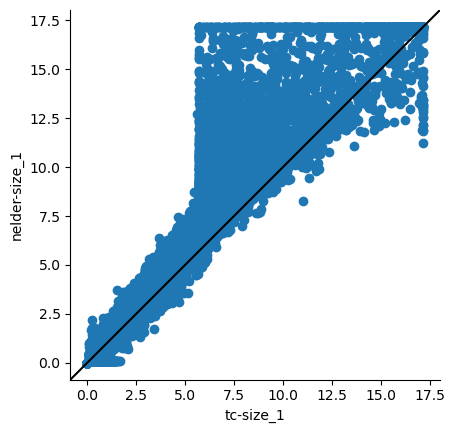

In [21]:
%matplotlib inline
for sub in sub_list:
    plt.figure()
    prf_multi[sub].scatter(
        'tc-size_1', 'nelder-size_1', 
        do_id_line=True,  #y_lim=[0,1],
        # dot_alpha=0.1,
    )

In [43]:
prf_objTC = TSPlotter(
    prf_params=prf_dataTC,
    model='gauss', 
    prfpy_model=gg,
    real_ts=ts_data,
)
prf_objBG = TSPlotter(
    prf_params=prf_dataBG,
    model='gauss', 
    prfpy_model=gg,
    real_ts=ts_data,
)
prf_objGR = TSPlotter(
    prf_params=prf_dataGR,
    model='gauss', 
    prfpy_model=gg,
    real_ts=ts_data,
)

prf_multi = PrfMulti(
    [prf_objBG, prf_objTC, prf_objGR], ['bg', 'tc', 'gr']
)


prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=8
include hrf = True
include rsq = True


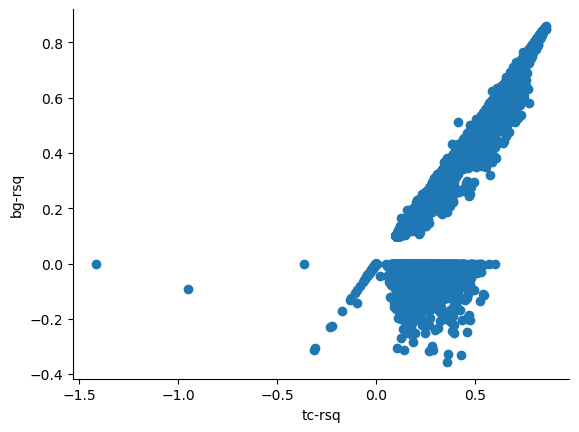

In [46]:
prf_multi.scatter('tc-rsq', 'bg-rsq', th={})

In [60]:
dag_make_custom_cmap(cmap_stack=['polar_starter', 'polar_starter_r'])
prf_multi.prf_obj['tc'].visual_field(dot_alpha=1, dot_size=1, dot_col='pol', dot_cmap='polar_starter', dot_vmin=-np.pi, dot_vmax=np.pi)

TypeError: dag_make_custom_cmap() got an unexpected keyword argument 'cmap_stack'